# Paahuni and Sam's Example overpasses:  

##### In this NB I'm just creating ETa and ETF for a few of the CO overpasses. At the bottom I'll put code you can use to export some of the intermediate products, ETa, ETo, NDVI, Tcorr....

## FrontMatter

In [1]:
try:
    import ee
except ModuleNotFoundError:
    !pip install earthengine-api
    import ee

In [2]:
# import packages
import pprint
from IPython.display import Image

In [3]:
# Import the SSEBop package, installing it first, if needed.
try:
    import openet.ssebop as ssebop_model
except ModuleNotFoundError:
    !pip install openet-ssebop
    import openet.ssebop as ssebop_model

In [4]:
# Initialize the Earth Engine package, initiating the authentication flow if needed.
# If you have done this in anaconda prompt/ terminal when you run this notebook that will work well.

try:
    ee.Initialize()
except ee.EEException:
    ee.Authenticate()
    ee.Initialize()

In [5]:
# visualization parameters
ndvi_palette = ['#EFE7E1', '#003300']
et_palette = [
    'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
    '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']
image_size = 768

## Overpass One: 2013_05_14

In [6]:
ls_id_5_14 = 'LC08_032034_20130514'
# wrs2_tiles = p033r033, p032r034, p033r034

In [7]:
landsat_img = ee.Image('LANDSAT/LC08/C02/T1_L2/'+ ls_id_5_14)

landsat_crs = landsat_img.select('SR_B3').projection().getInfo()['crs']
landsat_region = landsat_img.geometry().bounds(1, 'EPSG:4326')
landsat_dt = ee.Date(landsat_img.get('system:time_start'))

##### Fun initial Visualization

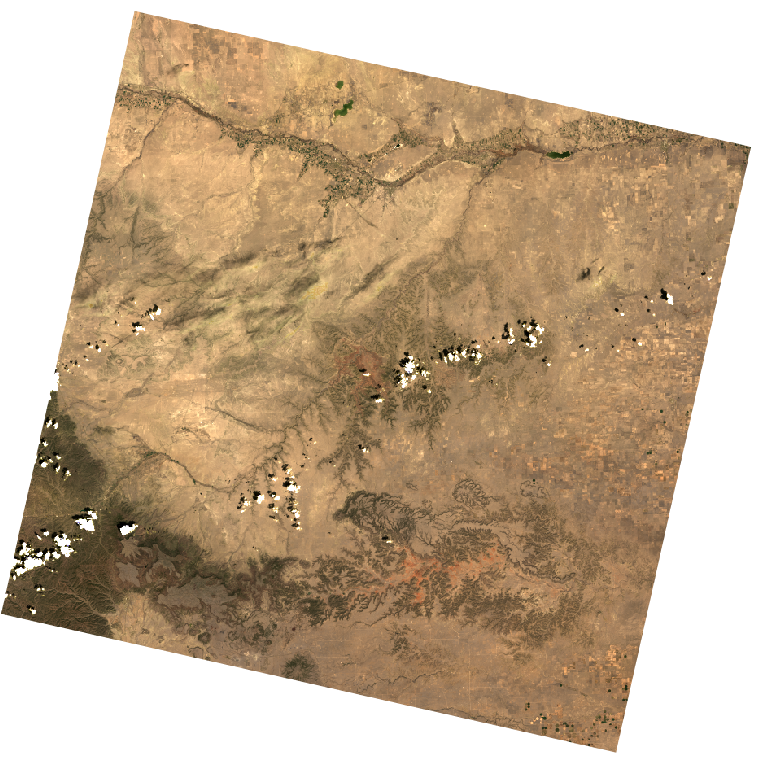

In [8]:
image_url = landsat_img.select(['SR_B4', 'SR_B3', 'SR_B2'])\
    .multiply([0.0000275, 0.0000275, 0.0000275])\
    .add([-0.2, -0.2, -0.2])\
    .getThumbURL({'min': 0.0, 'max': 0.3, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

##### Nice Cloud free image. Let's look at the rest of the components of this image.

In [14]:
# Build the SSEBop object from the Landsat image
model_obj = ssebop_model.Image.from_landsat_c2_sr(
    landsat_img, 
    tcorr_source='GRIDDED_COLD',
    # et_reference_source='projects/climate-engine/cimis/daily', 
    # et_reference_band='ETr_ASCE',
    et_reference_source='IDAHO_EPSCOR/GRIDMET', 
    et_reference_band='etr', 
    et_reference_factor=0.85,
    et_reference_resample='nearest',
    et_reference_date_type=''
)

## NDVI

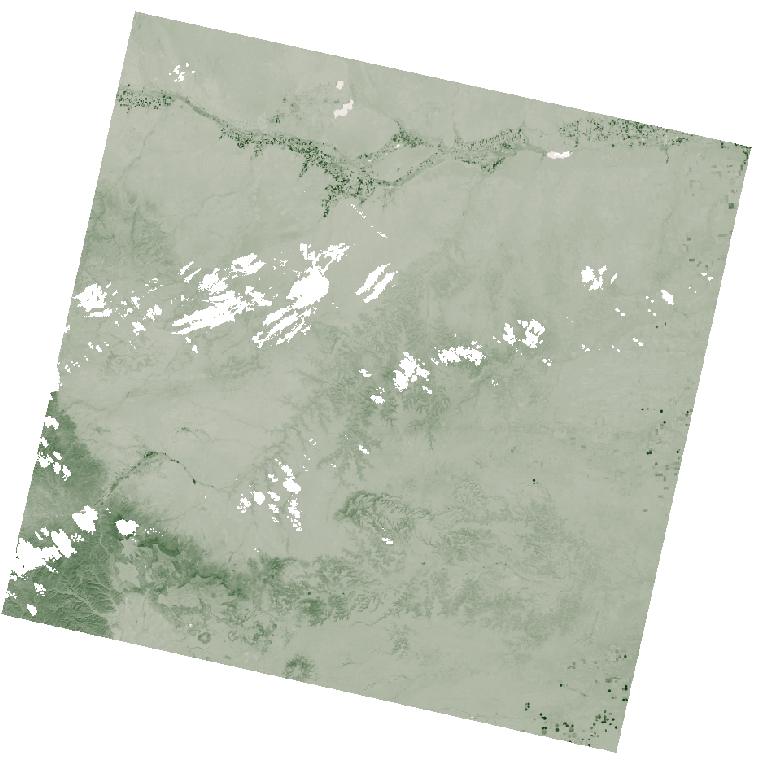

In [15]:
image_url = model_obj.ndvi\
    .getThumbURL({'min': -0.1, 'max': 0.9, 'palette': ndvi_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

# save as a variable for later
ndvi = model_obj.ndvi

## ET Fraction

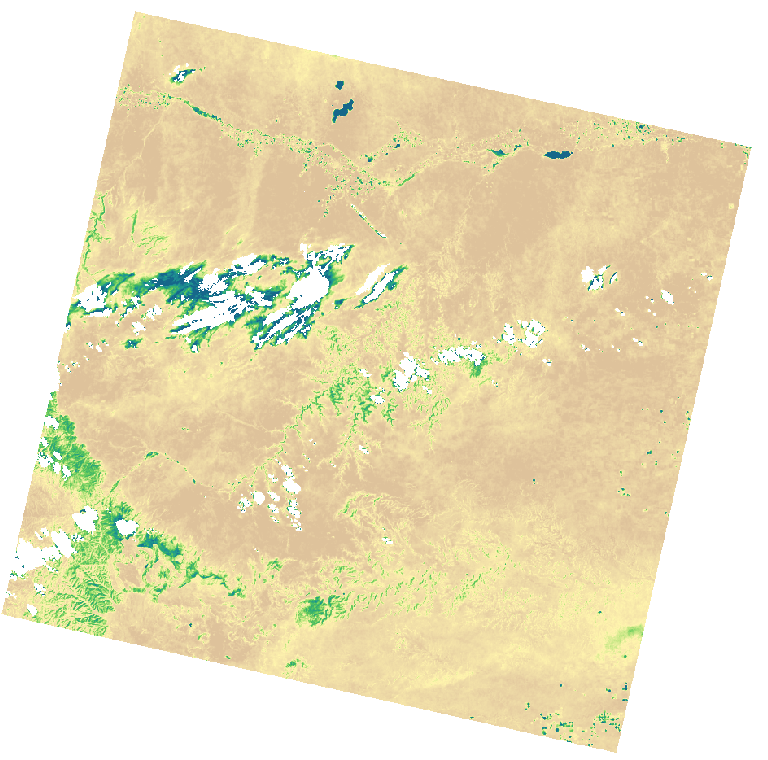

In [16]:
image_url = model_obj.et_fraction\
    .getThumbURL({'min': 0.0, 'max': 1.2, 'palette': et_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

# save as a variable for later
etf = model_obj.et_fraction

## Reference ET

In [13]:
# Clip and project to the Landsat image footprint and coordinate system
image_url = model_obj.et_reference\
    .getThumbURL({'min': 0.0, 'max': 12, 'palette': et_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

# save as a variable for later
etr = model_obj.et_reference

ValueError: unsupported et_reference_date_type: None

## And Finally, the model result is ETa: Actual ET ->

In [ ]:
image_url = model_obj.et\
    .getThumbURL({'min': 0.0, 'max': 15, 'palette': et_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

# save as a variable for later
et = model_obj.et

##### Get tcorr (hard to visualize for some reason) in order to export it further on down

In [17]:
tcorr = model_obj.tcorr_gridded_cold

## EXPORTING Results (ETa) and image ingredients for comparison with OS Code from Sam and Paahuni

##### The following helps us send images to google drive:

In [20]:
def ee_task_start(task, n=10):
    """Make an exponential backoff Earth Engine request"""
    output = None
    for i in range(1, n):
        try:
            task.start()
            break
        except Exception as e:
            time.sleep(i ** 2)
    return task

## Uncomment code in the cells below to export images to your google drive, changing the paths as appropriate:

In [ ]:
# ==== exporting tcorr ======
task = ee.batch.Export.image.toAsset(image=tcorr, description='tcorr'+landsat_id, assetId='users/username/dirlocation'+ landsat_id, region=landsat_region)
# start the task
print('starting')
ee_task_start(task=task)
print('task submitted')

In [ ]:
# ==== exporting ndvi ======
task = ee.batch.Export.image.toAsset(image=ndvi, description='ndvi'+landsat_id, assetId='users/username/dirlocation'+ landsat_id, region=landsat_region)
# start the task
print('starting')
ee_task_start(task=task)
print('task submitted')

In [ ]:
# ==== exporting ET Fraction ======
task = ee.batch.Export.image.toAsset(image=etf, description='etf'+landsat_id, assetId='users/username/dirlocation'+ landsat_id, region=landsat_region)
# start the task
print('starting')
ee_task_start(task=task)
print('task submitted')

In [ ]:
# ==== exporting ETr, Reference ET ======
task = ee.batch.Export.image.toAsset(image=etr, description='etr'+landsat_id, assetId='users/username/dirlocation'+ landsat_id, region=landsat_region)
# start the task
print('starting')
ee_task_start(task=task)
print('task submitted')

In [ ]:
# ==== exporting ETa, Actual ET for comparison with the Lysimeter, etc. ======
task = ee.batch.Export.image.toAsset(image=et, description='eta'+landsat_id, assetId='users/username/dirlocation'+ landsat_id, region=landsat_region)
# start the task
print('starting')
ee_task_start(task=task)
print('task submitted')